<a href="https://colab.research.google.com/github/110bender/HDR/blob/main/HDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Handwritten digit recognition (HDR)**
Backpropagation neural network with Pytorch ðŸ’¥ 

---


This project's aim is to realize a system to recognize handwritten digits and convert them to machine language. 

The system is developed using a backpropagation neural network trained by the MNIST dataset.

An *effective* feature extraction called [LLF (Local Line Fitting)](https://drive.google.com/file/d/16oAKR5FrQNRoWzxbLgYlUsO3vq2ZX5Im/view?usp=sharing) is used. The method, based on simple geometric operations, is very efficient and yields a relatively low-dimensional and distortion invariant representation. 

An important feature of the approach is that **no preprocessing** of the input image is required. A black & white or gray-scale pixel representation is directly used **without thinning, contour following, binarization**, etc. Therefore, high recognition **speed** can be achieved.


In [147]:
import torch
from torch import nn 
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
from sklearn.linear_model import LinearRegression

In [148]:
# Download train_data
train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [149]:
# Feature extraction function
def feature_extraction(image):

  feature_np = image.numpy()

  # Split image into 16 cells
  cells = [] #16

  x = np.vsplit(feature_np.reshape(28,28), 4)
  for i in range(len(x)):
    cells.extend(np.hsplit(x[i],4))

  cells_np = np.array(cells)

  # Extract 3 features from each cell
  feature_ex = [] #3*16

  for j in range(16):
    f1 = np.count_nonzero(cells_np[j] > 0.8)/7*7 #feature 1
    indices_nonzero = np.nonzero(cells_np[j] > 0.8)
    (y,x) = indices_nonzero
    if x.shape==(0,):
      f2=0.
      f3=1.
    else:
      x = x.reshape(-1, 1)
      y = y.reshape(-1, 1)
      reg = LinearRegression().fit(x, y)
      f2 = (2*float(reg.coef_))/(1+float(reg.coef_)**2) #feature 2
      f3 = (1-float(reg.coef_)**2)/(1+float(reg.coef_)**2) #feature 3

    feature_ex.append(f1)
    feature_ex.append(f2)
    feature_ex.append(f3)

  feature_ex_np = np.array(feature_ex).astype('float32')
  feature_ex = torch.as_tensor(feature_ex_np) #Don't allocate new memory

  return feature_ex

In [150]:
# Create new train data
new_train_data = []

for i in range (40000):
  feature_ex = feature_extraction(train_data[i][0])
  new_element = (feature_ex, train_data[i][1])
  new_train_data.append(new_element)

In [151]:
new_train_data[40000-1]

(tensor([ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  1.3000e+01,  1.6963e-01,  9.8551e-01,  3.0000e+00,
         -9.6000e-01,  2.8000e-01,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          1.4000e+01, -9.9966e-01, -2.5970e-02,  1.7000e+01,  7.7284e-01,
          6.3460e-01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  4.0000e+00,
          1.0000e+00, -2.2204e-16,  2.6000e+01, -4.2890e-01,  9.0335e-01,
          2.3000e+01, -9.6867e-01,  2.4835e-01,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.0000e+00,
         -1.1077e-01,  9.9385e-01,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00]),
 5)

In [152]:
# Define Train validation loaders
train, val = random_split(new_train_data, [35000, 5000])
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

In [153]:
# Define the model
class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(16*3, 50)
    self.l2 = nn.Linear(50, 50)
    self.do = nn.Dropout(0.1)
    self.l3 = nn.Linear(50, 10)
  def forward(self, x):
    h1 = nn.functional.relu(self.l1(x))
    h2 = nn.functional.relu(self.l2(h1))
    do = self.do(h2 + h1)
    output = self.l3(do)
    return output

model = ResNet()

In [154]:
# Define the optimzer
from torch import optim
optim = optim.SGD(model.parameters(), lr=1e-2)

In [155]:
# Define the loss
loss = nn.CrossEntropyLoss()

In [156]:
nb_epochs = 10
for epoch in range(nb_epochs):

  # Training loop
  train_loss = 0
  for batch in train_loader:
    feature, label = batch

    #1 forward 
    output = model(feature)

    #2 compute 
    L = loss(output, label)

    #3 clean
    model.zero_grad()

    #4 backward
    L.backward()

    #5 Apply
    optim.step()

    train_loss += L.item() #a tensor
    train_loss /= len(train_loader)


  # Validation loop
  valid_loss = 0
  correct = 0
  total = 0
  model.eval()
  for batch in val_loader:
    feature, label = batch

    #1 forward
    with torch.no_grad(): 
      output = model(feature) 

    #2 compute 
    L = loss(output, label)

    valid_loss +=  L.item()
    correct += torch.sum(torch.argmax(output, dim=1) == label).item()

  valid_loss /= len(val_loader)
  correct /= len(val_loader.dataset)

  print(f"epoch: {epoch+1}, train loss: {train_loss:.4f}, validation loss: {valid_loss:.4f}, correct predictions: {correct*100:.2f}%")


epoch: 1, train loss: 0.0007, validation loss: 0.8103, correct predictions: 74.96%
epoch: 2, train loss: 0.0005, validation loss: 0.6465, correct predictions: 79.26%
epoch: 3, train loss: 0.0004, validation loss: 0.5710, correct predictions: 81.62%
epoch: 4, train loss: 0.0004, validation loss: 0.5228, correct predictions: 82.98%
epoch: 5, train loss: 0.0003, validation loss: 0.4864, correct predictions: 83.94%
epoch: 6, train loss: 0.0003, validation loss: 0.4614, correct predictions: 84.64%
epoch: 7, train loss: 0.0003, validation loss: 0.4484, correct predictions: 84.90%
epoch: 8, train loss: 0.0003, validation loss: 0.4386, correct predictions: 85.32%
epoch: 9, train loss: 0.0003, validation loss: 0.4235, correct predictions: 85.74%
epoch: 10, train loss: 0.0003, validation loss: 0.4208, correct predictions: 85.96%


In [157]:
# Download test_data
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

In [158]:
# Create new test_data
new_test_data = []
for i in range (1000):
  feature_ex = feature_extraction(test_data[i][0])
  new_element = (feature_ex, test_data[i][1])
  new_test_data.append(new_element)

In [159]:
# Define test loader
test_loader = DataLoader(new_test_data, batch_size=32, shuffle=True)

In [160]:
# Test loop
test_loss = 0
correct = 0
total = 0

for batch in test_loader:
  feature, label = batch

  #1 forward
  with torch.no_grad(): 
    output = model(feature) 

  #2 compute 
  L = loss(output, label)

  test_loss +=  L.item()
  correct += torch.sum(torch.argmax(output, dim=1) == label).item()

test_loss /= len(test_loader)
correct /= len(test_loader.dataset)

print(f"correct predictions: {correct*100:.2f}%")

correct predictions: 83.00%


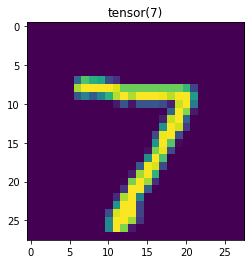

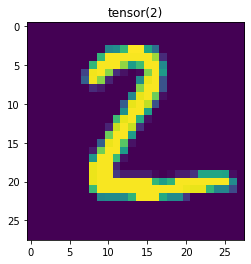

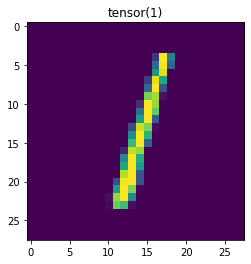

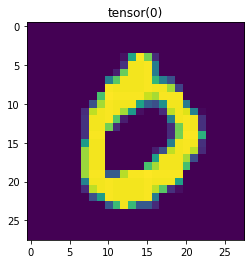

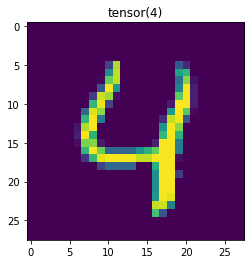

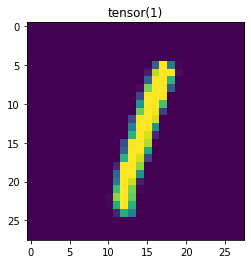

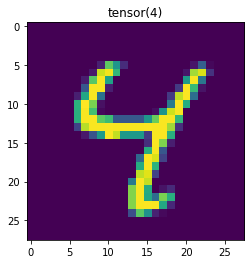

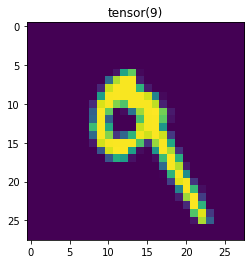

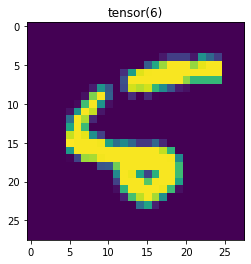

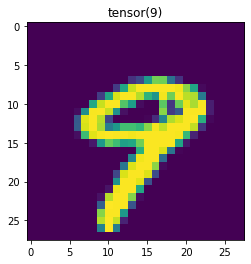

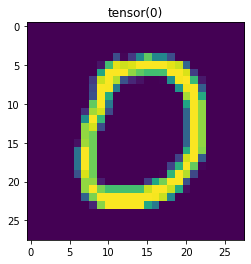

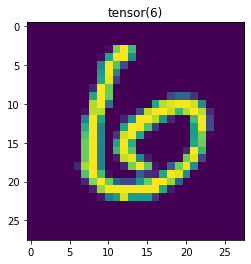

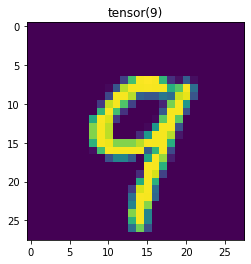

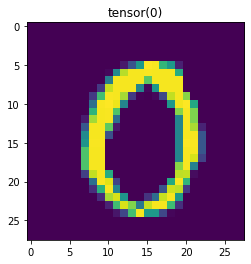

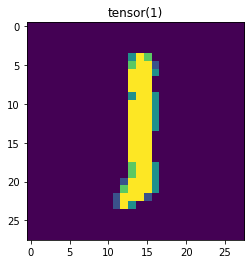

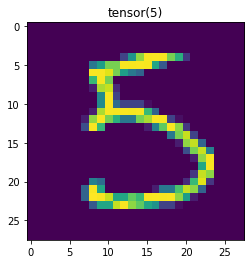

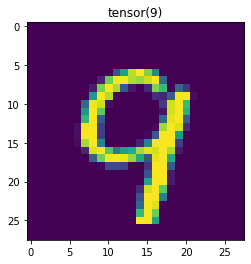

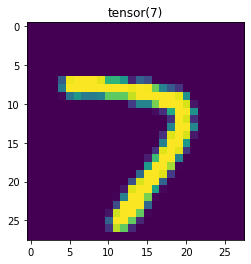

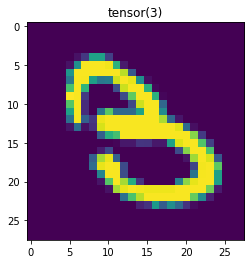

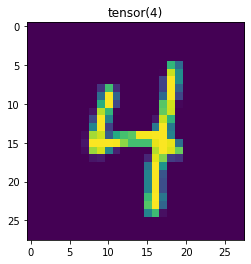

In [161]:
import matplotlib.pyplot as plt
for i in range (20):
  plt.imshow(test_data[i][0].view(28,28)) #real output
  image = feature_extraction(test_data[i][0])
  plt.title(torch.argmax(model(image))) #predicted output
  plt.show()

## ***By Bender & Benhima.***